In [156]:
#Paquetes utilizados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pandas import Series
import matplotlib as mpl
from statsmodels.tsa import seasonal

# Data preparation

## 1. Justificación

Para este estudio de series de tiempo, utilizamos una base de datos que describe las cargas transportadas por una empresa. En mi rol actual como coordinadora de operaciones, estoy involucrada en un análisis detallado de una empresa de transporte de cargas en Estados Unidos. Se ha observado que los tiempos de entrega no coinciden con las expectativas de los clientes, lo que ha afectado negativamente el nivel de servicio. Por ello, considero que esta base de datos es muy relevante para el análisis que realizaremos.

La [base de datos](https://www.kaggle.com/datasets/ramakrishnanthiyagu/delivery-truck-trips-data) (Ram Thiagu, 2018) incluye información clave, como la fecha de reserva de la carga, la fecha real de inicio del viaje, la fecha de entrega esperada y la fecha de entrega real. Además, contiene códigos de identificación para el camión, el conductor y el cliente asociados a cada carga.

En una primera fase, realizaremos un Análisis Exploratorio de Datos (EDA) para identificar patrones como los conductores con mayor cantidad de demoras y la tasa de servicio por cliente, entre otros. Posteriormente, el análisis de series de tiempo nos permitirá evaluar la demanda frente a la capacidad. El seguimiento de los camiones implica la presencia de despachadores disponibles para revisar el estado de los viajes, los conductores y los camiones. En promedio, la industria suele operar con un despachador por cada 10 camiones. Además, la cantidad de cargas requiere un número adecuado de camiones disponibles para su transporte.

Algunas consideraciones para este análisis son:
1. Se asumirá que todas las cargas son FTL (Full Truck Load), es decir, cada carga requiere un camión exclusivo, sin posibilidad de consolidación.
2. Se asumirá que los retrasos tanto en la entrega como en la recogida afectan el nivel de servicio. Sin embargo solo podemos analizar con respecto a retrasos en la entrega, pues no conocemos cuál es la fecha ideal de recogida y no podemos comparar.
3. Según el autor de la base de datos la variable trip_end_date no es un dato acertado para conocer la hora de llegada del conductor, por lo que no será tenida en cuenta en el estudio

## 2. Limpieza de datos

In [2]:
df=pd.read_excel("Delivery truck trip data (1).xlsx")
df=df.loc[df['Market/Regular ']=='Regular'] 
#Regular significa carga contratada, en mi caso se manejan cargas "Market" es decir del día a día, sin embargo esto es menor cantidad de datos para el análisis

En este dataframe también tenemos la información de las ciudades de entrega y recogida, así como latitud, longitud, sin embargo no realizaremos un análisis espacial, por lo que estás columnas serán eliminadas del dataframe.

In [3]:
cols=['BookingID','BookingID_Date', 'trip_start_date', 'Planned_ETA','Data_Ping_time','actual_eta','delay',
      'TRANSPORTATION_DISTANCE_IN_KM','Driver_Name','customerID','Material Shipped','vehicle_no']
df=df[cols]

In [4]:
print("La fecha de inicio del análisis es:",df['BookingID_Date'].min())
print("La fecha de finalización del análisis es:",df['BookingID_Date'].max())
print("1 año y apróximadamente 9 meses")

La fecha de inicio del análisis es: 2019-03-18 12:19:22
La fecha de finalización del análisis es: 2020-12-03 13:10:21
1 año y apróximadamente 9 meses


In [5]:
print("Hay",df.loc[pd.isna(df['actual_eta'])].shape[0],"cargas que todavía no han sido entregadas")

Hay 37 cargas que todavía no han sido entregadas


Para este caso en que tenemos cargas cuya fecha de entrega no ha sido confirmada, podemos comparar con respecto al ping_date, que es una variable de la base de datos tomada del GPS del camión, en USA conocido como ELD (Electronic Logging Device). Si el ping_date es mayor al planned_ETA significa que la carga está retrasada. 

Sin embargo, si es menor, deberíamos entrar a un análisis de lugar actual vs lugar de destino, calcular las millas que separan ambas locaciones, calcular las horas de manejo esperadas y revisar con respecto a las Log Hours del conductor cuántos días significa. En USA un conductor no puede manejar más de 11 horas seguidas durante un día, por lo que si faltaran 15 horas de manejo significarían dos días más de espera sumados a la fecha dictada por la variable de ping_date. Dado que 1) este análisis requiere de un manejo de coordenadas y distancias y 2) desconocemos la reglamentación de India, que parece ser el lugar de análisis de esta base de datos, estos casos los eliminaremos de nuestro dataframe.

In [6]:
delay=(df.loc[pd.isna(df['actual_eta'])]['Data_Ping_time']>df.loc[pd.isna(df['actual_eta'])]['Planned_ETA'])
#26 cargas True
#.index #Todas las filas que tengan valor True son cargas retrasadas

In [7]:
df.loc[delay[delay==True].index,'delay']='R'
print("Número de cargas antes de eliminar las que desconocemos su horario de entrega",df.shape)
df=df.drop(delay[delay==False].index)
print("Número de cargas después de eliminar las que desconocemos su horario de entrega",df.shape)
print("Se borraron 11 cargas, seguimos con 6800 datos")

Número de cargas antes de eliminar las que desconocemos su horario de entrega (6811, 12)
Número de cargas después de eliminar las que desconocemos su horario de entrega (6800, 12)
Se borraron 11 cargas, seguimos con 6800 datos


In [8]:
df.loc[pd.isna(df['delay']),'delay']='On time'
df['delay']=df['delay'].str.replace('R','Delayed')

In [9]:
print("Hay",df['vehicle_no'].nunique(),"camiones en todo el periodo de análisis")
print("Hay",df['Driver_Name'].nunique(),"conductores en todo el periodo de análisis")
print("Hay",df['customerID'].nunique(),"clientes únicos")

Hay 2303 camiones en todo el periodo de análisis
Hay 1354 conductores en todo el periodo de análisis
Hay 36 clientes únicos


## 3. Exploración de los datos
Ya teniendo la base de datos limpia, con la información que necesitamos, podemos realizar un análisis corto de los datos. En esta primera exploración buscamos entender qué información hay detrás del comportamiento de las cargas de esta empresa, un primer estudio de las variables y su comportamiento.

### Nivel de servicio para el Top 5 mejores clientes

In [10]:
piv1=df.pivot_table(index='customerID', columns='delay', aggfunc='size', fill_value=0).reset_index()
piv1['Total']=piv1['Delayed']+piv1['On time']
piv1['Service level (%)']=piv1['On time']/piv1['Total']
piv1 = piv1.sort_values(by='Total', ascending=False)

In [11]:
print("Porcentaje de cargas transportadas para nuestro mejor cliente:",(4092/6800)*100)

Porcentaje de cargas transportadas para nuestro mejor cliente: 60.1764705882353


C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

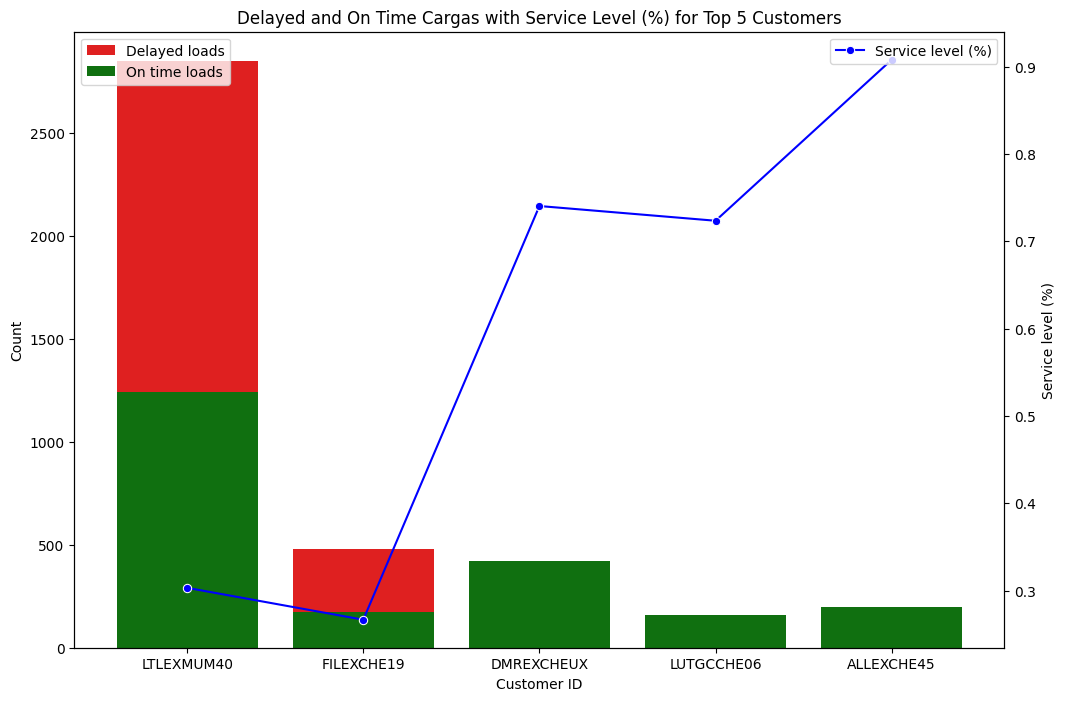

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(data=piv1.head(), x='customerID', y='Delayed', color='red', label='Delayed loads', ax=ax1)
sns.barplot(data=piv1.head(), x='customerID', y='On time', color='green', label='On time loads', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=piv1.head(), x='customerID', y='Service level (%)', color='blue', marker='o', ax=ax2, label='Service level (%)')
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Count')
ax1.legend(loc='upper left')
ax2.set_ylabel('Service level (%)')
ax2.legend(loc='upper right')
plt.title('Delayed and On Time Cargas with Service Level (%) for Top 5 Customers')
plt.show()

Con este análisis queda claro que el cliente que mayor número de cargas supone para la compañía con un 60.17%, recibe el segundo peor nivel de servicio de nuestro top 5 mejores clientes. Experimentó retraso en la entrega en 2851 ocasiones, solo en el 30.3% de cargas transportadas con nosotros recibió un nivel de servicio aceptable (Entendiendo nivel de servicio como sin retraso en la fecha de entrega planeada). Todos los clientes de nuestro top 5 han percibido demoras en la operación.

De este análisis se pueden desprender la tasa de retiro de los clientes en el tiempo, por ejemplo, o la reducción de la demanda de nuestros servicios en el tiempo. Por ahora no revisaremos cómo ha ido disminuyendo la cantidad de interés de nuestros clientes por nuestra empresa. Sino un análisis de capacidad para conocer si la flota de camiones, que al parecer es bastante alta, presenta problemas de cobertura o si por el contrario el seguimiento de las operaciones por parte de los despachadores a cargo, no está siendo eficiente y distintos conductores no tienen una corrección de ruta a tiempo.

### Nivel de servicio por conductor

In [13]:
piv1=df.pivot_table(index='Driver_Name', columns='delay', aggfunc='size', fill_value=0).reset_index()
piv1['Total']=piv1['Delayed']+piv1['On time']
piv1['Service level (%)']=piv1['On time']/piv1['Total']
piv1 = piv1.sort_values(by='Total', ascending=False)
piv1=piv1.loc[piv1['Total']>10] #los que han llevado mayor cantidad de cargas

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

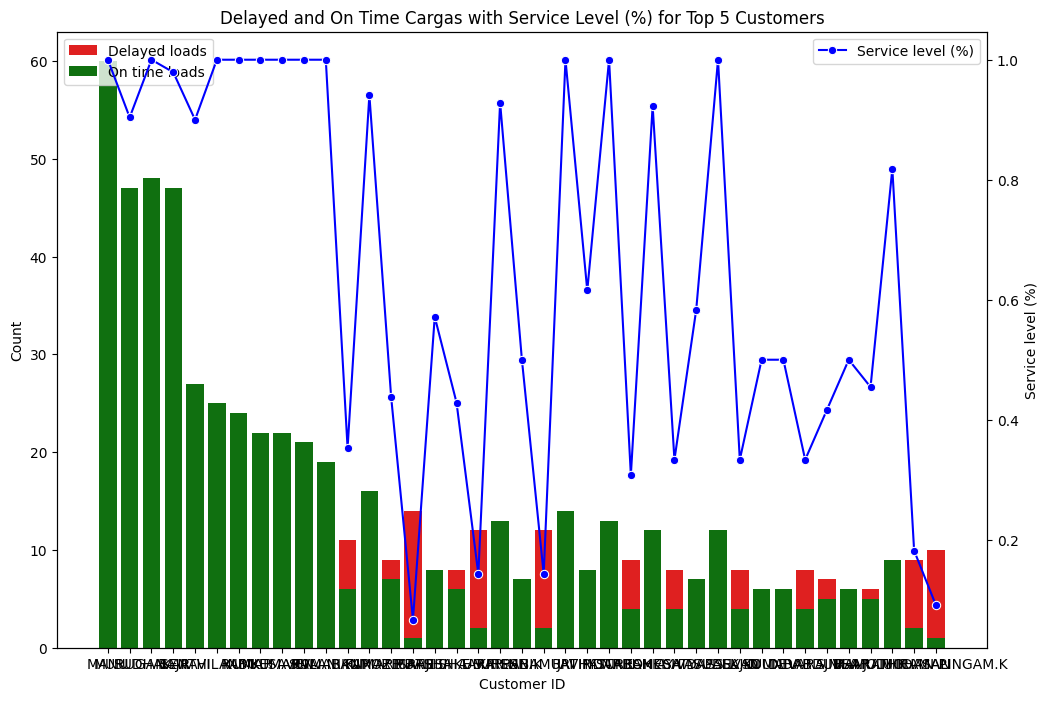

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(data=piv1, x='Driver_Name', y='Delayed', color='red', label='Delayed loads', ax=ax1)
sns.barplot(data=piv1, x='Driver_Name', y='On time', color='green', label='On time loads', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=piv1, x='Driver_Name', y='Service level (%)', color='blue', marker='o', ax=ax2, label='Service level (%)')
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Count')
ax1.legend(loc='upper left')
ax2.set_ylabel('Service level (%)')
ax2.legend(loc='upper right')
plt.title('Delayed and On Time Cargas with Service Level (%) for Top 5 Customers')
plt.show()

Si bien es cierto, no en todas las cargas se conoce el conductor asignado, al menos en este análisis de 3440 cargas, nos permite ver que el top 10 conductores que más cargas transportan tienen un nivel de servicio por encima del 90%. Estos datos los puede utilizar la empresa como input para bonificaciones, programas de fidelización del empleado, entre otros. En el caso de los conductores de bajo nivel de servicio es adecuado conocer qué despachador monitorea su operación y hacer un seguimiento más cercanos de las decisiones operativas que se toman durante la ejecución de la ruta, con el fin de determinar qué genera los retrasos y que acciones rápidas de reprogramación o para evitar retrasos no se están tomando a tiempo.

### Análisis de materiales transportados por los conductores

In [15]:
piv1=df.pivot_table(index='Material Shipped', columns= "delay", aggfunc='size', fill_value=0).reset_index()
piv1['Total']=piv1['Delayed']+piv1['On time']
piv1['Service level (%)']=piv1['On time']/piv1['Total']
piv1 = piv1.sort_values(by='Total', ascending=False)
piv1['freq_relativa']=piv1['Total']/6800
piv1['acum']=piv1['freq_relativa'].cumsum()
piv1=piv1.loc[piv1['Total']>30]
piv1

delay,Material Shipped,Delayed,On time,Total,Service level (%),freq_relativa,acum
86,AUTO PARTS,1089,407,1496,0.272059,0.220000,0.220000
476,GRS STARTER,216,35,251,0.139442,0.036912,0.256912
785,M70 STARTER MOTOR 12V 0.9KW,126,89,215,0.413953,0.031618,0.288529
365,EMPTY TRAYS,124,47,171,0.274854,0.025147,0.313676
1034,SIA114 12V 70A ALTERNATOR,104,55,159,0.345912,0.023382,0.337059
1082,SPARE PARTS AUTOMOBILE,110,44,154,0.285714,0.022647,0.359706
59,A114 Alternator(New Versa),60,86,146,0.589041,0.021471,0.381176
386,Empty trays,64,29,93,0.311828,0.013676,0.394853
351,EMPTY BIN,23,41,64,0.640625,0.009412,0.404265
1065,SOLENOID SWITCH,40,12,52,0.230769,0.007647,0.411912


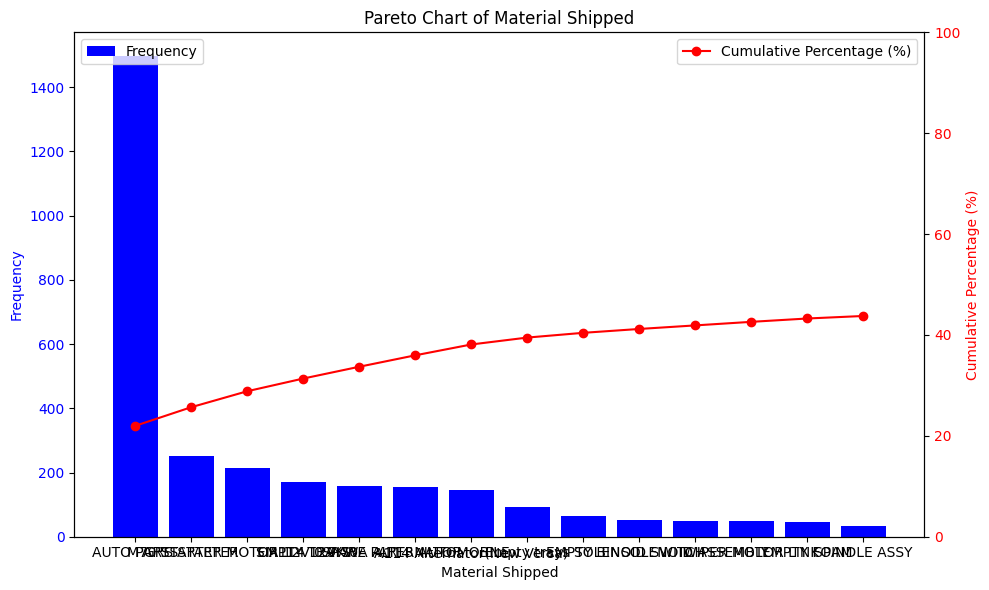

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(piv1['Material Shipped'], piv1['Total'], color='blue', label='Frequency')
ax1.set_xlabel('Material Shipped')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(piv1['Material Shipped'], piv1['acum'] * 100, color='red', marker='o', label='Cumulative Percentage (%)')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)
plt.title('Pareto Chart of Material Shipped')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=-45)
plt.show()

Con este resultado, concluimos que las auto parts presentan alto nivel de demanda en la empresa y de los 1496 transportes que se han realizado de este tipo de carga, solo el 27.2% ha sido entregado a tiempo. Cualquier modificación que se realice al flujo actual de operación se debe testear/revisar/verificar durante el envío de este tipo de carga, para conocer si el cambio surgió efecto y permite mejorar el tiempo de entrega de las 'autoparts'. En este punto también se pueden proponer mejoras en cuanto al tipo de vehículo que está transportando este material, puede ser requerido alguno que genere entregas más expeditas, de menor tamaño, como un cargo van y no vehículos de 40 o 53 pies, cuya maniobra en algunos lugares puede resultar costosa, lenta y peligrosa.

## 4. Preparación de la serie de tiempo

En este estudio, no tendremos en cuentas las sugerencias de mejoras planteadas durante el análisis exploratorio. Sino que observaremos el análisis de capacidad/demanda en el tiempo, que parece ser el verdadero problema de raíz de la empresa. No en la cantidad de conductores y camiones disponibles, pero en la planeación, ejecución y seguimiento de las rutas. Para eso prepararemos nuestros datos en el formato que una serie de tiempo lo requiere.

### Cambios en el tiempo del nivel de servicio

In [33]:
ts1=df.pivot_table(index='BookingID_Date', values= 'BookingID',columns='delay',aggfunc='size', fill_value=0).reset_index()
ts1['BookingID_Date'] = pd.to_datetime(ts1['BookingID_Date'])
ts1 = ts1.sort_values('BookingID_Date')
ts1['Total']=ts1['Delayed']+ts1['On time']
ts1['Service level (%)']=ts1['Delayed']/ts1['Total']*100
ts1['BookingID_Date'] = pd.to_datetime(ts1['BookingID_Date'])
ts1 = ts1.sort_values('BookingID_Date')

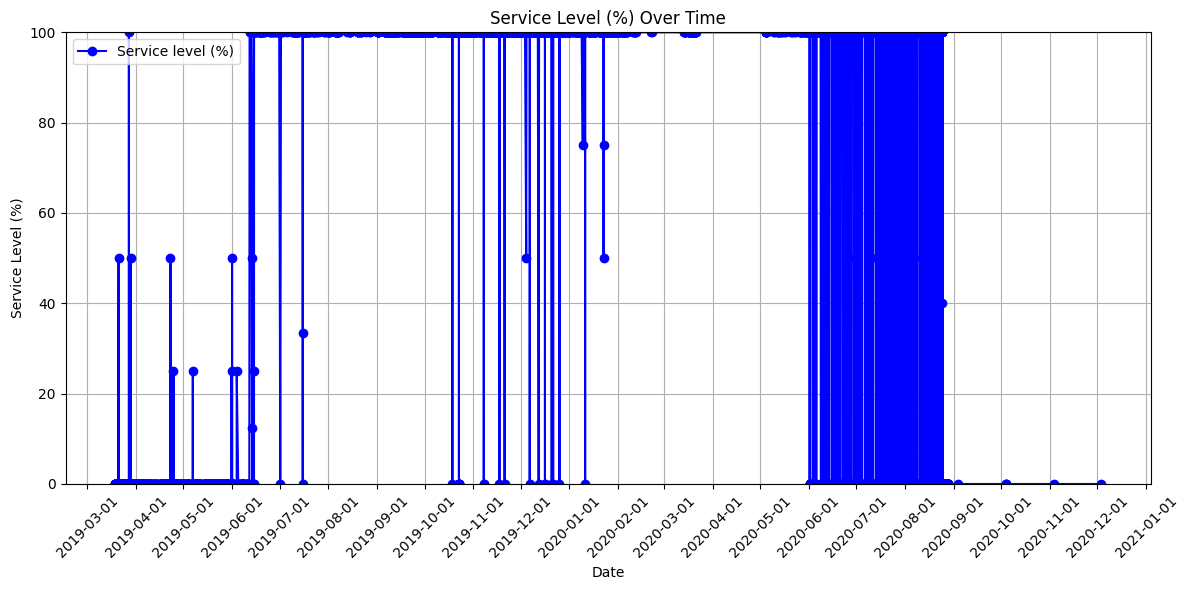

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts1['BookingID_Date'], ts1['Service level (%)'], color='blue', marker='o', linestyle='-', markersize=6, label='Service level (%)')
ax.set_title('Service Level (%) Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Service Level (%)')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.xticks(rotation=45)
ax.set_ylim(0, 100)
ax.grid(True)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Se observa en esta serie de tiempo que una primera parte del tiempo la empresa mantenía en mayor medida niveles de servicios bajos, donde el período de abril a julio de 2019 la mayor cantidad de casos presentaban niveles de servicios por debajo del 50%. En una segunda instancia, desde Julio hasta apróximadamante mayo de 2020, el nivel de servicio estuvo rondando en gran parte de los casos un 100%. Mientras que una tercera etapa de Mayo en adelante, existe mayor variabilidad entre el cumplimiento de nivel de servicio.

### Cargas reservadas al día por los despachadores

In [146]:
ts2=df.pivot_table(index='BookingID_Date', values= 'BookingID',aggfunc='count', fill_value=0).reset_index()
ts2['BookingID_Date'] = pd.to_datetime(ts2['BookingID_Date'])
ts2 = ts2.sort_values('BookingID_Date')

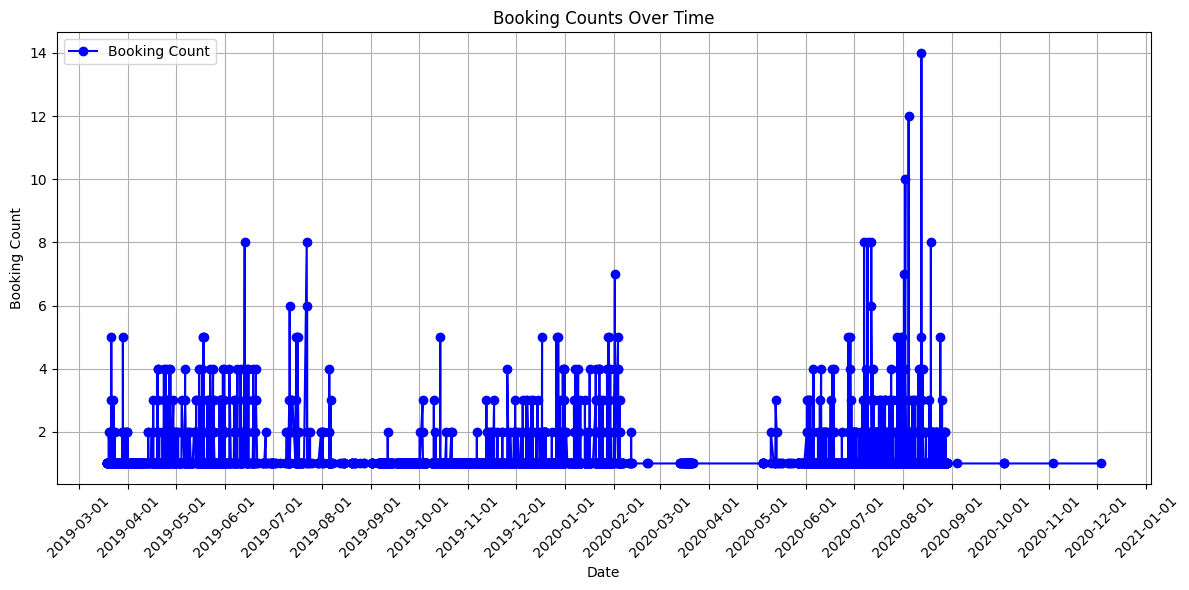

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts2['BookingID_Date'], ts2['BookingID'], color='blue', marker='o', linestyle='-', markersize=6, label='Booking Count')
ax.set_title('Booking Counts Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Booking Count')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.xticks(rotation=45)
ax.autoscale(axis='y')
ax.grid(True)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Esta es la primera serie de tiempo propuesta para el análisis. Corresponde al número de cargas reservadas por día en el período de un año y casi 9 meses de nuestra base de datos. Hay 3 etapas en esta serie de tiempo, lo decimos de esa forma por el período de Agosto a Noviembre de 2019 y el de enero a mayo de 2020, que separan la serie de tiempo en 3 momentos de análisis.

Observamos que aunque en la primera etapa donde el nivel de servicio fue bajo alto número de cargas eran reservadas al día, esta mala tasa de servicio no parece impactar visualmente el número de cargaas posibles reservadas al día por la compañía en la segunda etapa, pero sí posible la confiabilidad de los usuarios sobre ella. En una tercera etapa, el número de cargas parece aumentar en varias ocasiones con respecto a los dos primeros períodos.

*Considerando que son cargas contratadas puede ser porque en el segundo periodo se mejoró el nivel de servicio y por ende la confiabilidad de los clientes sobre las operaciones.*

### Número de cargas planeadas por entregar por día

In [38]:
ts3=df.pivot_table(index='Planned_ETA', values= 'BookingID',aggfunc='count', fill_value=0).reset_index()
ts3['Planned_ETA'] = pd.to_datetime(ts3['Planned_ETA'])
ts3 = ts3.sort_values('Planned_ETA')

En este punto observamos un comportamiento extraño en la serie de tiempo y notamos que hay dos valores que escaparon de la limpieza de dactos en la columna de "Planned_ETA" por lo cual los eliminaremos. Porque no solo se presentan mal calculados en esta columna, sino tambien en el "actual_eta" y "trip_start_date", por lo que resulta complicado revisar directamente, sin un análisis de coordenadas, si realmente son cargas demoradas y porque directamete nuestra columna de referencia de entrega a tiempo es la columna de "Planned_ETA".

In [39]:
df['Planned_ETA'] = pd.to_datetime(df['Planned_ETA'])
df['BookingID_Date'] = pd.to_datetime(df['BookingID_Date'])
min_booking_date = df['BookingID_Date'].min()
df=df.drop(df.loc[df['Planned_ETA'] < min_booking_date].index) #Continuamos con 6798 datos

ts3=df.pivot_table(index='Planned_ETA', values= 'BookingID',aggfunc='count', fill_value=0).reset_index()
ts3['Planned_ETA'] = pd.to_datetime(ts3['Planned_ETA'])
ts3 = ts3.sort_values('Planned_ETA')

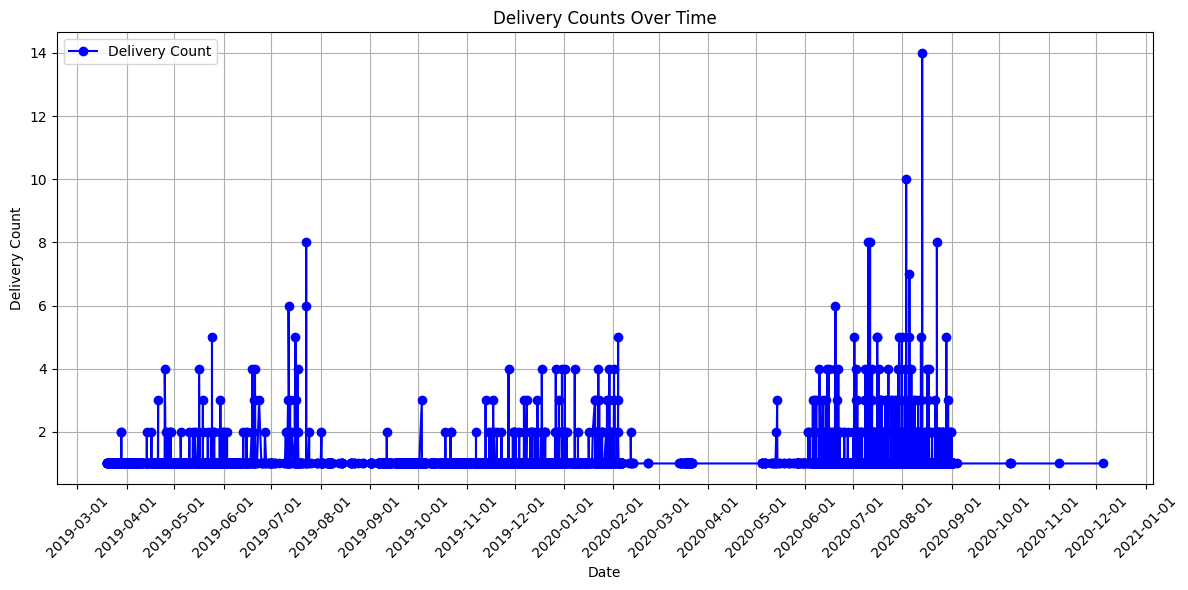

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts3['Planned_ETA'], ts3['BookingID'], color='blue', marker='o', linestyle='-', markersize=6, label='Delivery Count')
ax.set_title('Delivery Counts Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Delivery Count')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.xticks(rotation=45)
ax.autoscale(axis='y')
ax.grid(True)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Como era de esperarse, a mayor número de cargas reservadas, mayor es la cantidad de cargas que se planean entregar, comportamiento resultante en el período 3. Este punto es super importante, porque supone el análisis de la capacidad que tengo disponible, lo que ya gasté de recurso y la nueva demanda que surge a diario. Debo poder con mi parte operativa, reservar, negociar, monitorear y cobrar facturas de las cargas que entrego. Si los depsachadores realizan todo esto en simultáneo y supone un problema en la completitud del servicio existe un problema de capacidad operativa por solucionar. Este análisis de serie de tiempo nos podría apoyar en la estimación de esa demanada que requiero por día de conductores y despachadores.

## 5. Análisis Exploratorio EDA Serie de Tiempo

La serie de tiempo sobre la cual realizaremos los análisis será ts2 "Serie de Tiempo Cargas Reservadas por día", con el fin de determinar si se están comprometiendo al transporte de más cargas de las que la empresa puede cubrir. En este punto buscamos descomponer la serie temporal en sus componentes de tendencia, estacaionalidad y ciclos si existieran. Identificar patrones en la serie y predecir valores futuros que tomaría cada una, nos permitiría preparar los requerimientos de personal y recurso para cumplir con el nivel de servicio en cada caso.

### Partición de la serie de tiempo

El primer paso será revisar la cantidad de datos que tendríamos si separarámos los 3 períodos que hemos mencionado anteriormente. Los puntos de corte serán:
1. Septiembre de 2019
2. Abril de 2020

In [145]:
ts21=ts2.loc[ts2['BookingID_Date']<'2019-09-01'] #997 datos
ts22=ts2.loc[(ts2['BookingID_Date']>='2019-09-01')&(ts2['BookingID_Date']<'2020-04-01')] #2240 datos
ts23=ts2.loc[ts2['BookingID_Date']>='2020-04-01'] #2689 datos

ts2 = ts2.loc[ts2['BookingID_Date']>'2019-09-01']

A priori tomaremos la serie de tiempo desde septiembre de 2019. Esto dado que notamos en el análisis del nivel de servicio que la empresa presentaba muy bajos niveles durante ese período aspecto que cambió para el corte 2 y 3. Esto reduce la base de datos en 997 datos, por lo que continuaremos entonces con 4929.

### Decomposición de la serie actual

Exploremos el comportamiento de la serie actualmente, y verifiquemos si existen tendencias o estacionalidades en los datos.

In [82]:
ts2['BookingID_Date_fix'] = ts2['BookingID_Date'].dt.strftime('%Y-%m')
ts2.index = ts2['BookingID_Date_fix']
frecuencia = pd.infer_freq(ts2.index)
print("Frecuencia: ", frecuencia)

Frecuencia:  None


In [ ]:
ts23['BookingID_Date_fix'] = ts23['BookingID_Date'].dt.strftime('%Y-%m')
ts23.index = ts23['BookingID_Date_fix']
frecuencia = pd.infer_freq(ts23.index)
print("Frecuencia: ", frecuencia)

Frecuencia:  None


In [84]:
ts22['BookingID_Date_fix'] = ts22['BookingID_Date'].dt.strftime('%Y-%m')
ts22.index = ts22['BookingID_Date_fix']
frecuencia = pd.infer_freq(ts22.index)
print("Frecuencia: ", frecuencia)

Frecuencia:  None


No se identifica en la serie de tiempo general ni tampoco en los subconjuntos de la serie que determinamos, que exista una frecuencia de repetición de algún patrón. Esto se debe a la variabilidad de los datos y también al comportamiento no continuo de la operación.

Lo que sí pudiéramos encontrar serían patrones estacionales, dado que el comportamiento de la demanda por servicios de transporte varía durante el año y encuentra picos dependiendo en qué estación se encuentra el país, inversiones gubernamentales en ciertos cuartiles, entre otras cosas.

In [96]:
trend_model = LinearRegression(fit_intercept=True)
trend_model.fit(np.arange(ts2.shape[0]).reshape((-1,1)), ts2['BookingID'])
pred = trend_model.predict(np.arange(ts2.shape[0]).reshape((-1, 1)))
r2 = r2_score(ts2['BookingID'], pred)
r2

0.0007403479302402483

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 [Text(-1000.0, 0, '2020-08'),
  Text(0.0, 0, '2019-09'),
  Text(1000.0, 0, '2019-11'),
  Text(2000.0, 0, '2020-01'),
  Text(3000.0, 0, '2020-07'),
  Text(4000.0, 0, '2020-08'),
  Text(5000.0, 0, ''),
  Text(6000.0, 0, '')])

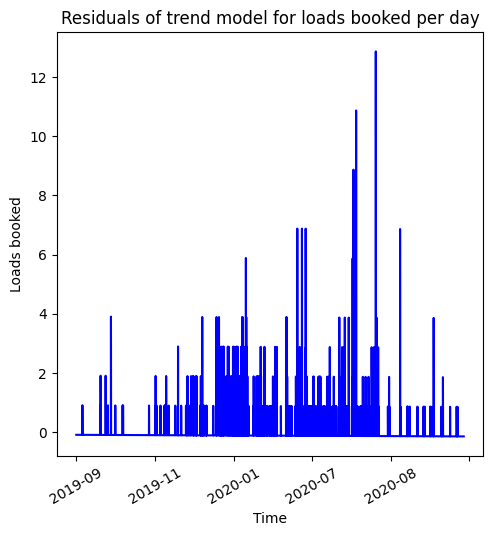

In [90]:
residuals = np.array(ts2['BookingID']) - trend_model.predict(np.arange(ts2.shape[0]).reshape((-1,1)))
plt.figure(figsize=(5.5, 5.5))
pd.Series(data=residuals, index=ts2.index).plot(color='b')
plt.title('Residuals of trend model for loads booked per day')
plt.xlabel('Time')
plt.ylabel('Loads booked')
plt.xticks(rotation=30)

El R2 del modelo de regresión lineal es bastante bajo, no se ajusta en absoluto a los valores de la serie de tiempo. No existe ni tendencia ni estacionalidad en los datos. Comprobemos qué dicta la prueba de Dickey-Fuller con respecto a la estacionariedad de esta serie.

In [107]:
#H0: La serie no es estacionaria
#H1: La serie es estacionaria
adf_result = adfuller(ts2['BookingID'], autolag='AIC')
adf_result[1]

1.1924879690639473e-29

En este caso la serie es estacionaria. Ya comprobamos con esto porqué en definitiva no muestra tendencias y estacionalidades. Podemos realizar un análisis de cuartiles para ver mejor su comportamiento.

In [111]:
series = ts2['BookingID']
series = Series(series)
series.describe()

count    4929.000000
mean        1.119497
std         0.569200
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        14.000000
Name: BookingID, dtype: float64

Observando este comportamiento en cuartiles, podría resultar adecuado hacer un remuestreo de los datos de diarios a semanales. Con el fin de aumentar la cantidad de cargas reservadas en cada observación.

### Remuestreo de la serie de tiempo

Dado que existen varios días de la serie de tiempo que no tienen cargas reservadas y se convierten en puntos muertos a lo largo del tiempo, los datos se están sesgando a una media de 1 y picos de comportamiento no pueden ser identificados fácilmente. Con el fin de mejorar las observaciones, realizaremos una agrupación semanal de los datos. Si ese es el caso, entonces podemos hacer un análisis con toda la serie de tiempo que teníamos antes, agregando el período 1, entendiendo que para identificar patrones estacionales, es necesario equiparar el pasado.

In [148]:
ts2=df.pivot_table(index='BookingID_Date', values= 'BookingID',aggfunc='count', fill_value=0).reset_index()
ts2['BookingID_Date'] = pd.to_datetime(ts2['BookingID_Date'])
ts2 = ts2.sort_values('BookingID_Date')

In [149]:
ts2.index = ts2['BookingID_Date']
ts2_r = ts2['BookingID'].resample('W').sum()
ts2 = pd.DataFrame(ts2_r)

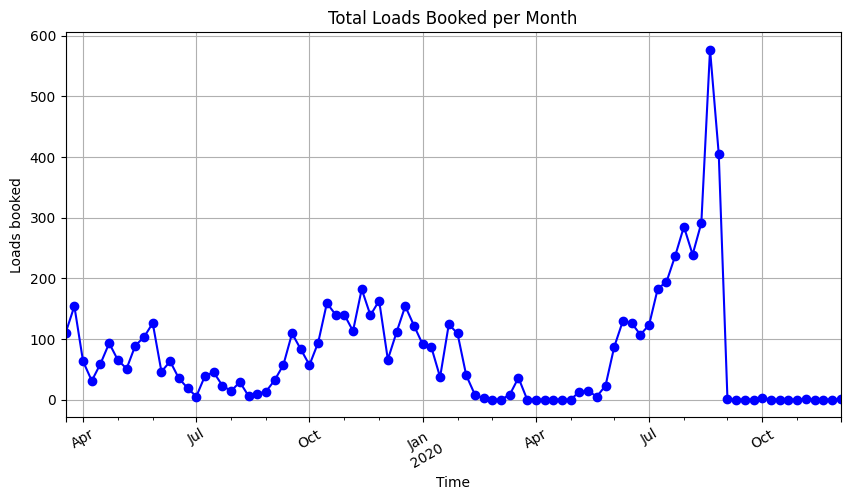

In [150]:
plt.figure(figsize=(10, 5))
mpl.rc('text', usetex=False)
ts2_r.plot(color='b', marker='o')
plt.title('Total Loads Booked per Month')
plt.xlabel('Time')
plt.ylabel('Loads booked')
plt.xticks(rotation=30)
plt.grid()
plt.show()

### Decomposición nueva serie de tiempo

Dado que se ha modificado la serie de tiempo analizada, procederemos a realizar nuevamente una decomposición para conocer si existe algún componente de estacionalidad o tendencia o si la serie es estacionaria.

In [154]:
#H0: La serie no es estacionaria
#H1: La serie es estacionaria
adf_result = adfuller(ts2['BookingID'], autolag='AIC')
adf_result[1]

0.11794883732355421

El p_valor en la prueba Dickey-Fuller en esta ocasión es mayor a 0.05, por lo que no rechaza la hipótesis nula y concluye que la serie no es estacionaria. En este nuevo análisis, haremos uso de statsmodel.sa para descomponer la serie de tiempo en su componente de tendencia, estacionalidad y ruido. Dado que la serie de tiempo está agrupada por semanas, haremos uso de period = 4, para reflejar una posible estacionalidad mensual.

In [159]:
decompose_model = seasonal.seasonal_decompose(ts2.BookingID.tolist(), period= 4, model='additive')

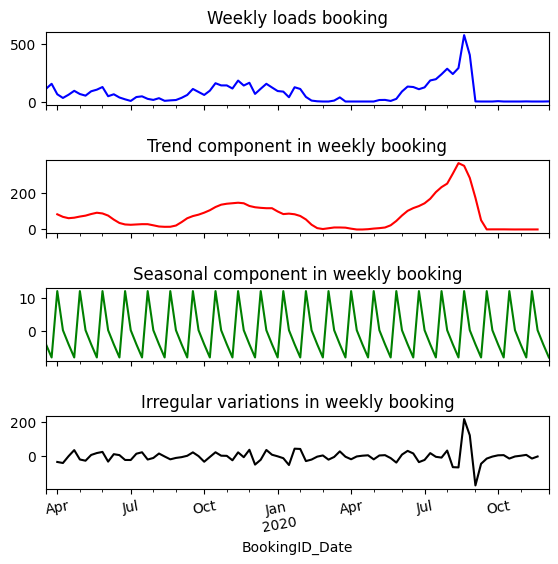

In [161]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

ts2['BookingID'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Weekly loads booking')

pd.Series(data=decompose_model.trend, index=ts2.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component in weekly booking')

pd.Series(data=decompose_model.seasonal, index=ts2.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component in weekly booking')

pd.Series(data=decompose_model.resid, index=ts2.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations in weekly booking')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0);
plt.xticks(rotation=10);

Algunos períodos en la serie de tiempo muestran tendencia,sobre todo el correspondiente a la tercera partición. Además, aparentemente existe un patrón estacional mensual en la serie, lo que es congruente con las estacionalidades que suelen existir en la demanda de distintos productos o servicios.

## 6. Conclusiones

El análisis exploratorio de los datos permitió identificar que era necesario agrupar los datos por semana dada la variabilidad diaria de la demanda por transporte de las cargas. Con el fin de reducir el impacto en la reducción de los datos por la agrupación, se hizo uso de toda la serie de tiempo disponible y se encontró en el análisis de componentes que en algunos períodos de tiempo existe tendencias a la alza y que hay un componente de estacionalidad marcado en la serie.

Esto del análisis de las fechas de entrega y reserva de carga, además debe estar acompañado con un análisis en el tiempo de la cantidad de camiones y conductores con que cuento para cada etapa, en su retención, adquisición o despido/venta del recurso. Esto podría suponer la integración de distintas series de tiempo que influyen la una sobre la otra. La cantidad de cargas reservadas con respecto a la cantidad de cargas que se deben entregar por día y la cantidad de recursos que utilizo y requiero para ir cumpliendo con esas entregas. 

El enfoque en revisión de literatura que continúa estará enfocado en la predicción y manejo de la demanda por servicios de transporte que se han presentado anteriormente. Con la base de datos que tenemos podemos conectar la seris de tiempo de los recursos con la serie de tiempo de la demanda, que fue la analizada durante esta entrega. Modelos como por ejemplo: VAR, SARIMAX, entre otros, permiten predecir la serie de tiempo de una variable con respecto a la interacción de varias series de tiempo que parten de variables exógenas.

Un posible output de un modelo de serie de tiempo para este caso de estudio, me permitiría entonces conocer cómo se comportará el nivel de servicio para mis clientes. De manera que yo pueda predecirlo si mejoras en la planeación de las rutas, despacho de las cargas y reducción del desperdicio de tiempo por parte de los conductores son aplicadas. Un buen nivel de servicio me permite asegurar la confiabilidad que tengan sobre mi operación y la rentabilidad y competitividad en el mercado de mi empresa. Continuemos entonces en el siguiente capítulo con la revisión de literatura.